In [1]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import keras

from collections import Counter
from imblearn.over_sampling import SMOTE 

from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,precision_score,f1_score,recall_score
from sklearn import preprocessing
from sklearn import svm
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD

from tensorflow.keras.applications import DenseNet121

import matplotlib.pyplot as plt

import pickle
import joblib
from joblib import dump, load

In [5]:
data_path="train_images/"
file = "train.csv"
image_size = 150

In [6]:
data = pd.read_csv(file)

In [7]:
#data = data.replace({0:"No DR", 1:"Mild", 2:"Moderate", 3:"Severe",4:"Proliferative DR"})

In [8]:
#data = data.replace({0:"No DR", 1:"Mild", 2:"Clear DR", 3:"Clear DR",4:"Clear DR"})

In [9]:
data = data.replace({0:"No DR", 1:"Mild DR", 2:"Mild DR", 3:"Clear DR",4:"Clear DR"})

In [10]:
output_nodes = len(set(list(data['diagnosis'])))

In [11]:
output_nodes

3

In [12]:
file_names=list(data['id_code'])

In [13]:
print(Counter(list(data['diagnosis'])))

Counter({'No DR': 1805, 'Mild DR': 1369, 'Clear DR': 488})


In [14]:
labels=data['diagnosis'].values.ravel()

In [15]:
def image_processing(data_path,file_names,img_size):
    dataset_tumor = []
    for file_name in file_names:
        file=cv2.imread(data_path+file_name+'.png', cv2.IMREAD_COLOR) 
        file_resize=cv2.resize(file,(img_size,img_size))/255.
        dataset_tumor.append(file_resize)
    tumor_data = np.array(dataset_tumor)
    tumor_data = tumor_data.reshape(-1,img_size,img_size,3)
    return tumor_data

In [16]:
#x = image_processing(data_path,file_names,image_size)

In [17]:
#np.save('Project Assets/x_image_data', x)

In [18]:
x = np.load('Project Assets/x_image_data.npy')

In [19]:
#x = np.load('Project Assets/x_image_data_SMOTE.npy')

In [20]:
#labels = np.load('Project Assets/SMOTE_labels.npy', allow_pickle=True)

In [21]:
x_train_val,x_test,y_train_val,y_test = train_test_split(x,labels,test_size=0.2)

In [22]:
ohe = OneHotEncoder(handle_unknown = "ignore", sparse=False)
ohe = ohe.fit(labels.reshape(-1,1))
y_train_val = ohe.transform(np.array(y_train_val).reshape(-1,1))
y_test = ohe.transform(np.array(y_test).reshape(-1,1))
dump(ohe, 'Project Assets/ohe_encoder.joblib') 

['Project Assets/ohe_encoder.joblib']

In [23]:
def build_alexnet():
    model = Sequential()

    model.add(Conv2D(filters=96, input_shape=(image_size,image_size,3), kernel_size=(11,11),\
     strides=(4,4), padding='valid'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    model.add(BatchNormalization())


    # Passing it to a dense layer
    model.add(Flatten())

    # 1st Dense Layer
    model.add(Dense(4096, input_shape=(image_size*image_size*3,)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())


    model.add(Dense(4096))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    #model.add(Dropout(0.5))
    
    model.add(Dense(output_nodes, activation='softmax'))
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['acc']
    )
    
    return model

In [24]:
model = build_alexnet()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 35, 35, 96)        34944     
                                                                 
 activation (Activation)     (None, 35, 35, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 17, 17, 96)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 17, 17, 96)       384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 256)       614656    
                                                                 
 activation_1 (Activation)   (None, 17, 17, 256)       0

In [25]:
def train_alexnet(x_train_val, y_train_val):

    ohe = joblib.load('Project Assets/ohe_encoder.joblib')

    kf = KFold(n_splits=3,shuffle=True)
    k_number = 0
    
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_f1score = []
    
    
    print("AlexNet training with 3-Fold Cross Validation.")
    for train_index, test_index in kf.split(x_train_val):
        x_train, x_val = x_train_val[train_index], x_train_val[test_index]
        y_train, y_val = y_train_val[train_index], y_train_val[test_index]
        
        model = build_alexnet()
        
        history1 = model.fit(x_train,y_train,epochs=15, validation_split = 0.2)
        
        acc_history = history1.history['acc']
        val_acc_history = history1.history['val_acc']
        loss_history = history1.history['loss']
        val_loss_history = history1.history['val_loss']
        
        plt.plot(history1.history['acc'])
        plt.plot(history1.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        plt.plot(history1.history['loss'])
        plt.plot(history1.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        

        print("The highest validation acc is {}".format(np.max(val_acc_history)))
        
        result=model.predict(x_val)
        result_class = tf.one_hot(np.argmax(result, axis=1), depth = output_nodes)
        
        result_class = ohe.inverse_transform(result_class)
        y_val_class = ohe.inverse_transform(y_val)

        val_accuracy.append(accuracy_score(result_class, y_val_class))
        val_precision.append(precision_score(result_class, y_val_class,average='macro'))
        val_f1score.append(f1_score(result_class, y_val_class,average='macro'))
        val_recall.append(recall_score(result_class, y_val_class,average='macro'))

        average_val_accuracy=sum(val_accuracy)/len(val_accuracy)
        average_val_precision=sum(val_precision)/len(val_precision)
        average_val_recall=sum(val_recall)/len(val_recall)
        average_val_f1score=sum(val_f1score)/len(val_f1score)
        
        print("AlexNet 3-Fold CV:")
        print("Average Acc: %.4f" %(average_val_accuracy))
        print("Average Precision: %.4f" %(average_val_precision))
        print("Average recall: %.4f" %(average_val_recall))
        print("Average F1 Score: %.4f \n" %(average_val_f1score))
        
    model.save('Project Assets/AlexNet_Model')

AlexNet training with 3-Fold Cross Validation.
Epoch 1/15
49/49 [==============================] - 7s 45ms/step - loss: 0.8137 - acc: 0.6989 - val_loss: 3.0793 - val_acc: 0.3887
Epoch 2/15
49/49 [==============================] - 1s 27ms/step - loss: 0.5925 - acc: 0.7636 - val_loss: 2.4103 - val_acc: 0.3990
Epoch 3/15
49/49 [==============================] - 1s 27ms/step - loss: 0.5205 - acc: 0.7924 - val_loss: 1.8376 - val_acc: 0.3811
Epoch 4/15
49/49 [==============================] - 1s 27ms/step - loss: 0.5036 - acc: 0.8040 - val_loss: 1.9543 - val_acc: 0.3529
Epoch 5/15
49/49 [==============================] - 1s 27ms/step - loss: 0.5130 - acc: 0.7931 - val_loss: 1.1871 - val_acc: 0.4987
Epoch 6/15
49/49 [==============================] - 1s 27ms/step - loss: 0.5185 - acc: 0.7931 - val_loss: 0.7129 - val_acc: 0.7059
Epoch 7/15
49/49 [==============================] - 1s 27ms/step - loss: 0.4775 - acc: 0.8072 - val_loss: 0.6258 - val_acc: 0.7724
Epoch 8/15
49/49 [==================

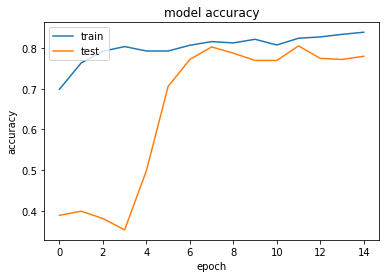

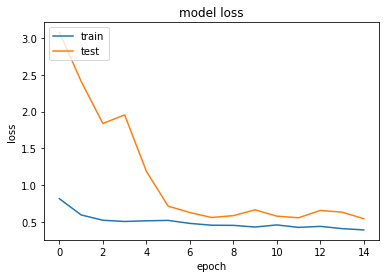

The highest validation acc is 0.8056265711784363
AlexNet 3-Fold CV:
Average Acc: 0.7963
Average Precision: 0.6231
Average recall: 0.6309
Average F1 Score: 0.6091 

Epoch 1/15
49/49 [==============================] - 3s 41ms/step - loss: 0.8742 - acc: 0.7196 - val_loss: 1.7580 - val_acc: 0.5013
Epoch 2/15
49/49 [==============================] - 1s 27ms/step - loss: 0.5555 - acc: 0.7753 - val_loss: 3.2843 - val_acc: 0.4297
Epoch 3/15
49/49 [==============================] - 1s 27ms/step - loss: 0.5539 - acc: 0.7926 - val_loss: 1.8198 - val_acc: 0.3862
Epoch 4/15
49/49 [==============================] - 1s 27ms/step - loss: 0.4911 - acc: 0.8054 - val_loss: 1.7518 - val_acc: 0.3964
Epoch 5/15
49/49 [==============================] - 1s 27ms/step - loss: 0.4936 - acc: 0.7983 - val_loss: 1.5142 - val_acc: 0.3862
Epoch 6/15
49/49 [==============================] - 1s 27ms/step - loss: 0.4683 - acc: 0.8047 - val_loss: 2.0917 - val_acc: 0.4322
Epoch 7/15
49/49 [==============================] 

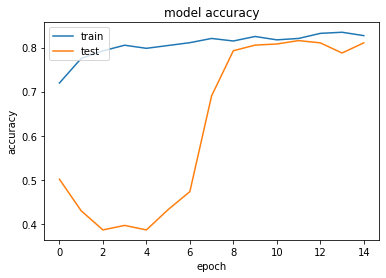

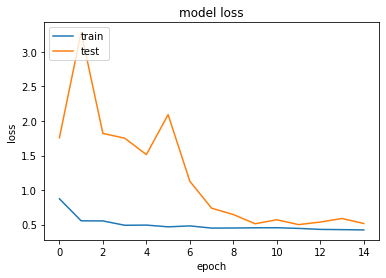

The highest validation acc is 0.8158567547798157
AlexNet 3-Fold CV:
Average Acc: 0.8018
Average Precision: 0.6340
Average recall: 0.6481
Average F1 Score: 0.6227 

Epoch 1/15
49/49 [==============================] - 2s 33ms/step - loss: 0.9703 - acc: 0.6953 - val_loss: 4.3173 - val_acc: 0.3708
Epoch 2/15
49/49 [==============================] - 1s 27ms/step - loss: 0.5529 - acc: 0.7913 - val_loss: 4.3770 - val_acc: 0.3529
Epoch 3/15
49/49 [==============================] - 1s 27ms/step - loss: 0.5202 - acc: 0.7964 - val_loss: 1.9277 - val_acc: 0.3785
Epoch 4/15
49/49 [==============================] - 1s 27ms/step - loss: 0.4992 - acc: 0.8035 - val_loss: 2.3161 - val_acc: 0.3708
Epoch 5/15
49/49 [==============================] - 1s 28ms/step - loss: 0.4818 - acc: 0.8118 - val_loss: 2.1637 - val_acc: 0.3529
Epoch 6/15
49/49 [==============================] - 1s 28ms/step - loss: 0.5007 - acc: 0.7990 - val_loss: 1.3965 - val_acc: 0.5652
Epoch 7/15
49/49 [==============================] 

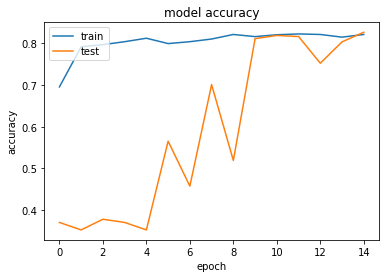

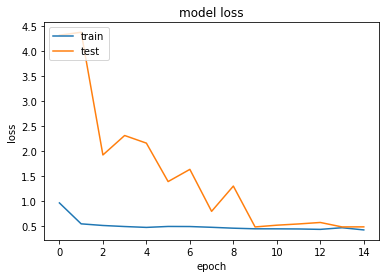

The highest validation acc is 0.8260869383811951
AlexNet 3-Fold CV:
Average Acc: 0.8105
Average Precision: 0.6400
Average recall: 0.7085
Average F1 Score: 0.6266 

INFO:tensorflow:Assets written to: Project Assets/AlexNet_Model\assets


In [26]:
train_alexnet(x_train_val, y_train_val)

Accuracy for test data: 0.7858117326057299


<Figure size 504x504 with 0 Axes>

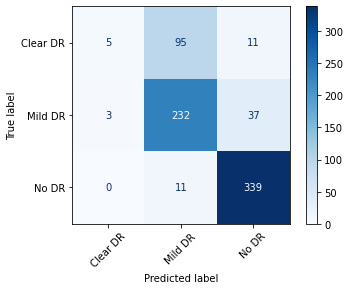

              precision    recall  f1-score   support

    Clear DR       0.62      0.05      0.08       111
     Mild DR       0.69      0.85      0.76       272
       No DR       0.88      0.97      0.92       350

    accuracy                           0.79       733
   macro avg       0.73      0.62      0.59       733
weighted avg       0.77      0.79      0.73       733



In [27]:
model = keras.models.load_model('Project Assets/AlexNet_Model')
ohe = joblib.load('Project Assets/ohe_encoder.joblib')

result=model.predict(x_test)
result_class = tf.one_hot(np.argmax(result, axis=1), depth = output_nodes)

result_class = ohe.inverse_transform(result_class)
y_test_class = ohe.inverse_transform(y_test)

acc = accuracy_score(result_class, y_test_class)
print("Accuracy for test data:", acc)

plt.figure(figsize = (7,7))
ConfusionMatrixDisplay.from_predictions(y_test_class, result_class, cmap = 'Blues')
plt.xticks(rotation=45)
plt.show()
print(classification_report(y_test_class, result_class))